# Style transfer
In style transfer:


Content image: This image and the artistic image are put into the pretrained net to obtain Content Features. From that, we get a Content Loss.

Style image: This image and the artistic image are put into the pretrained net to obtain Style Features. From that, we get a style Loss.

Total Loss = Style Loss + Content Loss

In [30]:
import numpy as np
from PIL import Image
import torch
from torch.optim import Adam
from torchvision import transforms
from torch.nn.functional import mse_loss
from torchvision import models

In [31]:
vgg = models.vgg16(pretrained=True).features


/Users/elvist/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elvist/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
vgg = vgg.to("mps")

In [33]:
vgg._modules.items()
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [40]:
preprocess_steps = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

content_img = Image.open('style/elvis.jpg').convert('RGB')
content_img = preprocess_steps(content_img) 
# transpose from C, H, W to H, W, C
# content_img = content_img.transpose(0, 2)
content_img = torch.unsqueeze(content_img, 0).to("mps")
print(content_img.shape)


style_img = Image.open('style/portrait.jpeg').convert('RGB')
style_img = preprocess_steps(style_img) 
# transpose from C, H, W to H, W, C
# style_img = content_img.transpose(0, 2)
style_img = torch.unsqueeze(style_img, 0).to("mps")
print(style_img.shape)


torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


In [41]:
# features extraction 
# Extract features corresponding to the layer '0', '5', '10', '19', '21', '28'

LOSS_LAYERS = {'0': 'conv1_1',
               '5': 'conv2_1',
               '10': 'conv3_1',
               '19': 'conv4_1',
                '21': 'conv4_2',
               '28': 'conv5_1'}

def extract_features(x, model):
    features= {}
    for name, layer in model._modules.items(): # For each name and layer in the pretrained vgg model
        x = layer(x) # Compute the output of this layer

        if name in LOSS_LAYERS:
            features[LOSS_LAYERS[name]] = x # put it in the features dict
    return features

content_img_features = extract_features(content_img, vgg)
style_img_features = extract_features(style_img, vgg)

In [42]:
#

def calc_gram_matrix(tensor):
    _, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)
    gram_matrix = torch.mm(tensor, tensor.t())
    gram_matrix = gram_matrix.div(C * H * W) # normalization required
    return gram_matrix

style_features_gram_matrix = {layer: calc_gram_matrix(style_img_features[layer]) for layer in style_img_features}

style_features_gram_matrix

{'conv1_1': tensor([[0.0039, 0.0032, 0.0036,  ..., 0.0009, 0.0000, 0.0017],
         [0.0032, 0.0039, 0.0032,  ..., 0.0008, 0.0000, 0.0010],
         [0.0036, 0.0032, 0.0038,  ..., 0.0008, 0.0000, 0.0016],
         ...,
         [0.0009, 0.0008, 0.0008,  ..., 0.0004, 0.0000, 0.0003],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0017, 0.0010, 0.0016,  ..., 0.0003, 0.0000, 0.0015]],
        device='mps:0', grad_fn=<DivBackward0>),
 'conv2_1': tensor([[1.7430e-04, 8.0608e-05, 3.3994e-04,  ..., 2.9483e-04, 1.6227e-06,
          5.1838e-05],
         [8.0608e-05, 4.3461e-03, 1.7867e-03,  ..., 2.5956e-03, 1.1185e-03,
          2.3354e-03],
         [3.3994e-04, 1.7867e-03, 5.1812e-03,  ..., 2.7758e-03, 1.7475e-03,
          2.2749e-03],
         ...,
         [2.9483e-04, 2.5956e-03, 2.7758e-03,  ..., 7.4775e-03, 3.7386e-03,
          3.0112e-03],
         [1.6227e-06, 1.1185e-03, 1.7475e-03,  ..., 3.7386e-03, 8.1673e-03,
          3.8165e-03],
         [5.183

In [44]:

weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.6,
           'conv4_1': 0.4, 'conv5_1': 0.2}

target = content_img.clone().requires_grad_(True)

optimizer = Adam([target], lr=0.003)

In [45]:
# Train the model

for i in range(1, 1000):
    target_features = extract_features(target, vgg)

    content_loss = mse_loss(target_features['conv4_2'], content_img_features['conv4_2'])

    style_loss = 0

    for layer in weights:

        target_feature = target_features[layer]
        target_gram_matrix = calc_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]

        layer_loss = mse_loss(target_gram_matrix, style_gram_matrix) * weights[layer]

        style_loss += layer_loss
    total_loss = 1000000 * style_loss + content_loss

    if i % 10 == 0:
        print(f"Epoch {i}:, Style Loss : {style_loss}, Content Loss : {content_loss}")

    optimizer.zero_grad()

    total_loss.backward(retain_graph=True)

    optimizer.step()

# Get target image
mean = (0.485, 0.456, 0.406)  # Imagenet mean and std
std = (0.229, 0.224, 0.225)

def tensor_to_image(tensor):

    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()

    image = image.transpose(1, 2, 0)
    image *= np.array(std) + np.array(mean)

    image = image.clip(0, 1)

    return image


Epoch 10:, Style Loss : 3.319677716717706e-06, Content Loss : 0.29076912999153137
Epoch 20:, Style Loss : 2.1679300061805407e-06, Content Loss : 0.32790979743003845
Epoch 30:, Style Loss : 1.646003738642321e-06, Content Loss : 0.33680662512779236
Epoch 40:, Style Loss : 1.3693347682419699e-06, Content Loss : 0.3313988149166107
Epoch 50:, Style Loss : 1.2024466968796332e-06, Content Loss : 0.32454827427864075
Epoch 60:, Style Loss : 1.097695758289774e-06, Content Loss : 0.3148169219493866
Epoch 70:, Style Loss : 1.0218321904176264e-06, Content Loss : 0.308372437953949
Epoch 80:, Style Loss : 9.657333066570573e-07, Content Loss : 0.3017864525318146
Epoch 90:, Style Loss : 9.203291142512171e-07, Content Loss : 0.2971983850002289
Epoch 100:, Style Loss : 8.83990139755042e-07, Content Loss : 0.29279011487960815
Epoch 110:, Style Loss : 8.541396141481528e-07, Content Loss : 0.2884848713874817
Epoch 120:, Style Loss : 8.283933539132704e-07, Content Loss : 0.2855048179626465
Epoch 130:, Style 

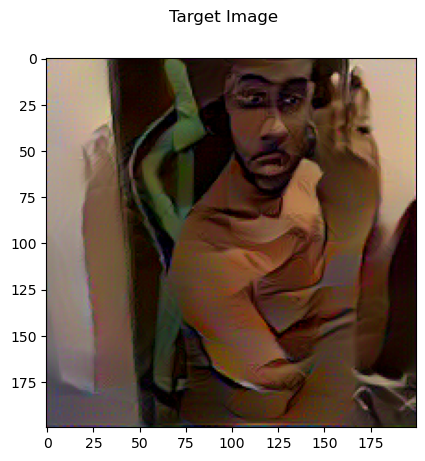

In [46]:
import matplotlib.pyplot as plt
img = tensor_to_image(target)
fig = plt.figure()
fig.suptitle('Target Image')
plt.imshow(img)